# Проект для «Викишоп»

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества *F1* не меньше 0.75. 

**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

## Подготовка

In [1]:
%%capture
!pip install wordcloud;

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
import re
import warnings


from nltk.corpus import stopwords
from wordcloud import WordCloud

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer


from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import f1_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier

nltk.download('stopwords')
stopwords = set(stopwords.words('english'))


warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/ilyasmirnov/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
data = pd.read_csv('./toxic_comments.csv')
data.head(10)

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0
5,"""\n\nCongratulations from me as well, use the ...",0
6,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1
7,Your vandalism to the Matt Shirvington article...,0
8,Sorry if the word 'nonsense' was offensive to ...,0
9,alignment on this subject and which are contra...,0


In [4]:
#пропусков нет, тип данных соответствует
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159571 non-null  object
 1   toxic   159571 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ MB


In [5]:
#посмотрели дубли
data.duplicated().sum()

0

In [6]:
#лишних значений нет
data['toxic'].unique()

array([0, 1])

Лемматизируем комментарии и очистим лишние символы регулярным выражением:

In [7]:
def clear_text(text):
    tokenized = nltk.word_tokenize(text)
    joined = ' '.join(tokenized)
    clear_text = re.sub(r'[^a-zA-Z]', ' ', joined)
    clear_text = " ".join(clear_text.split())
    clear_text = clear_text.lower()
    return clear_text

data['cl_text'] = data['text'].apply(clear_text)
data = data.drop(['text'], axis=1)

data.head()

,toxic,cl_text
0,0,explanation why the edits made under my userna...
1,0,d aww he matches this background colour i m se...
2,0,hey man i m really not trying to edit war it s...
3,0,more i ca n t make any real suggestions on imp...
4,0,you sir are my hero any chance you remember wh...


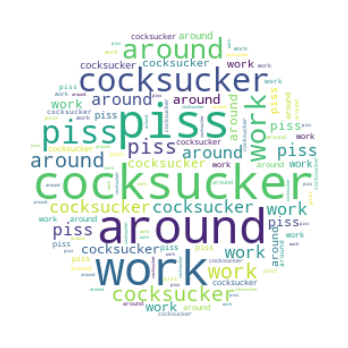

In [8]:
x, y = np.ogrid[:300, :300]

mask = (x - 150) ** 2 + (y - 150) ** 2 > 130 ** 2
mask = 255 * mask.astype(int)

toxic_commment = data['cl_text'][data['toxic'] == 1].values.astype('U')

wc = WordCloud(background_color="white", repeat=True, mask=mask, stopwords=stopwords, random_state=45)
wc.generate(toxic_commment[0])

plt.figure(figsize=(15, 10), dpi=45)
plt.axis("off")
plt.imshow(wc, interpolation="bilinear")
plt.show()

Вывод:

    - пропусков нет, тип данных соответствует;
    - дублей нет;
    - уникальные значения в столбце 'toxic' в порядке;
    - лемматизировали и очистили от лишних символов данные в столбце 'text', а так же в облаке слов показали слова, которые чаще всего встречаются - cocksucker, piss.

## Обучение

Разобьем данные на выборки и переведем слова в векторный вид методом tf_idf:

In [9]:
features = data['cl_text']
target = data['toxic']


features_train, features_test, target_train, target_test = train_test_split(features, target, 
                                                                            test_size=0.3, random_state=42)

#tf_idf
count_tf_idf = TfidfVectorizer(stop_words=stopwords)


features_train_tf = count_tf_idf.fit_transform(features_train)
features_test_tf = count_tf_idf.transform(features_test)

Теперь обучим следующие модели:

    - DecisionTreeClassifier;
    - LogisticRegression;
    - SGDClassifier.

### DecisionTreeClassifier

In [10]:
pipeline = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('dtc', DecisionTreeClassifier()),
])
# соберем словарь параметров
parameters = {
    'dtc__max_depth':[50,100], 'dtc__min_samples_leaf':[10,30], 'dtc__random_state':[42]
}
# проведем поиск лучших параметров и обучим лучшую модель
grid_search = GridSearchCV(pipeline, parameters, verbose=100,
                          cv=5, scoring='f1')
grid_search.fit(features_train, target_train)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[CV] dtc__max_depth=50, dtc__min_samples_leaf=10, dtc__random_state=42 
[CV]  dtc__max_depth=50, dtc__min_samples_leaf=10, dtc__random_state=42, score=0.667, total=  26.6s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   26.6s remaining:    0.0s
[CV] dtc__max_depth=50, dtc__min_samples_leaf=10, dtc__random_state=42 
[CV]  dtc__max_depth=50, dtc__min_samples_leaf=10, dtc__random_state=42, score=0.684, total=  27.1s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   53.8s remaining:    0.0s
[CV] dtc__max_depth=50, dtc__min_samples_leaf=10, dtc__random_state=42 
[CV]  dtc__max_depth=50, dtc__min_samples_leaf=10, dtc__random_state=42, score=0.673, total=  26.1s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  1.3min remaining:    0.0s
[CV] dtc__max_depth=50, dtc__min_samples_leaf=10, dtc__random_state=42 
[CV]  dtc__max_depth=50, dtc__m

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('vect', CountVectorizer()),
                                       ('tfidf', TfidfTransformer()),
                                       ('dtc', DecisionTreeClassifier())]),
             param_grid={'dtc__max_depth': [50, 100],
                         'dtc__min_samples_leaf': [10, 30],
                         'dtc__random_state': [42]},
             scoring='f1', verbose=100)

In [11]:
print('Лучшие параметры: ', grid_search.best_params_)

Лучшие параметры:  {'dtc__max_depth': 50, 'dtc__min_samples_leaf': 10, 'dtc__random_state': 42}


In [12]:
print('F1 модели DecisionTreeClassifier на обучающей выборке: ', grid_search.best_score_)

F1 модели DecisionTreeClassifier на обучающей выборке:  0.6795782226719961


In [13]:
mod_dtc = DecisionTreeClassifier(max_depth=50, min_samples_leaf=10, random_state=42)
mod_dtc.fit(features_train_tf, target_train)
pred = mod_dtc.predict(features_test_tf)
f1_dtc = f1_score(target_test, pred)
print('F1_score модели DecisionTreeClassifier: ', f1_dtc)

F1_score модели DecisionTreeClassifier:  0.7042627701968361


### LogisticRegression

In [14]:
%%time

mod_lr = LogisticRegression()
params = [{'solver':['newton-cg', 'lbfgs', 'liblinear'], 'random_state':[42]}]

gsearch_lr = GridSearchCV(mod_lr, params, scoring='f1',cv=3)
gsearch_lr.fit(features_train_tf, target_train)

CPU times: user 49.6 s, sys: 590 ms, total: 50.2 s
Wall time: 12.7 s


GridSearchCV(cv=3, estimator=LogisticRegression(),
             param_grid=[{'random_state': [42],
                          'solver': ['newton-cg', 'lbfgs', 'liblinear']}],
             scoring='f1')

In [15]:
print('Лучшие параметры: ', gsearch_lr.best_params_)

Лучшие параметры:  {'random_state': 42, 'solver': 'liblinear'}


In [16]:
print('F1 модели LogisticRegression на обучающей выборке: ', gsearch_lr.best_score_)

F1 модели LogisticRegression на обучающей выборке:  0.6834256884691143


In [17]:
mod_lr = LogisticRegression(solver = 'liblinear', random_state = 42)
mod_lr.fit(features_train_tf, target_train)
pred = mod_lr.predict(features_test_tf)
f1_lr = f1_score(target_test, pred)
print('F1_score модели LogisticRegression: ', f1_lr)

F1_score модели LogisticRegression:  0.7280966767371602


### SGDClassifier

In [18]:
%%time

mod_sgd = SGDClassifier()
params = [{'loss':['hinge', 'log', 'modified_huber'],
                'learning_rate':['constant', 'optimal', 'invscaling', 'adaptive'],
                'eta0':[0.01, 0.1, 0.2, 0.3, 0.5], 
                'class_weight':['balanced'],
                'random_state':[42]}]

gsearch_sgd = GridSearchCV(mod_sgd, params, scoring='f1',cv=3)
gsearch_sgd.fit(features_train_tf, target_train)

CPU times: user 4min 8s, sys: 1.3 s, total: 4min 9s
Wall time: 2min 2s


GridSearchCV(cv=3, estimator=SGDClassifier(),
             param_grid=[{'class_weight': ['balanced'],
                          'eta0': [0.01, 0.1, 0.2, 0.3, 0.5],
                          'learning_rate': ['constant', 'optimal', 'invscaling',
                                            'adaptive'],
                          'loss': ['hinge', 'log', 'modified_huber'],
                          'random_state': [42]}],
             scoring='f1')

In [19]:
print('Лучшие параметры: ', gsearch_sgd.best_params_)

Лучшие параметры:  {'class_weight': 'balanced', 'eta0': 0.2, 'learning_rate': 'adaptive', 'loss': 'modified_huber', 'random_state': 42}


In [20]:
print('F1 модели SGDClassifier на обучающей выборке: ', gsearch_sgd.best_score_)

F1 модели SGDClassifier на обучающей выборке:  0.7523522926633378


In [21]:
mod_sgd = SGDClassifier()
mod_sgd.set_params(**gsearch_sgd.best_params_)
mod_sgd.fit(features_train_tf, target_train)
pred = mod_sgd.predict(features_test_tf)
f1_sgd = f1_score(target_test, pred)
print('F1_score модели SGDClassifier: ', f1_sgd)

F1_score модели SGDClassifier:  0.7561243144424131


Выведем таблицу моделей:

In [22]:
index = ['DecisionTreeClassifier', 
         'LogisticRegression',
         'SGDClassifier']
data = {'F1 score':[f1_dtc, f1_lr, f1_sgd]}

scores_data = pd.DataFrame(data=data, index=index)
scores_data['Выполнение задачи'] = scores_data['F1 score'] > 0.75
scores_data

,F1 score,Выполнение задачи
DecisionTreeClassifier,0.704263,False
LogisticRegression,0.728097,False
SGDClassifier,0.756124,True


## Выводы

В ходе работы, мы:

    - провели предобработку данных;
    - в столбце 'text' убрали лишние символы и лемматизировали его;
    - разбили данные на выборки и использовали tf_idt;
    - обучили модели с гиперпараметрами и нашли метрику f1.

Самой лучшей моделью, как видим выше, оказалась SGDClassifier с метрикой f1 равной 0.76 с гиперпараметрами: class_weight = 'balanced', 'eta0'= 0.3, 'learning_rate'= 'adaptive', 'loss'= 'modified_huber', 'random_state'= 42. Время обучения этой модели 2min 43s так же лучше, чем у DecisionTreeClassifier (13min 8s) и LogisticRegression(2min 55s). Это говорит нам, что токсичные комментарии находятся лучше.